# 사전학습된 VGG16에서 특징맵 추출하기

CNN 모델의 Architecture은 크게 
1. Localization 작업 수행(Feature map extraction) 
2. Classification 작업 수행

으로 이루어진다.

<전체>

이미지의 특징맵을 추출하고 추출된 특징맵을 사용자 입력 이미지와 유사도 계산을 통해 유사도가 가장 높은 앨범 이미지 10개를 출력하고자 한다.


이 코드는 단순하게 이미지의 특징맵을 추출하는 과정이다.

참고(https://deep-eye.tistory.com/14)

In [1]:
import cv2
from matplotlib import pyplot
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.preprocessing.image import img_to_array

In [2]:
# 모델 불러오기
base_model = VGG16(weights='imagenet')
# 모델 확인하기
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

합성곱층은 여러가지 필터를 가지고 필터마다 하나의 특성 맵을 출력한다.
여러 특성 맵을 쌓는 것이 더 좋다.
즉 하나의 합성곱 층이 입력에 여러 필터를 동시 적용하여 입력에 있는 여러 특성을 감지할 수 있다.

위의 VGG16 모델을 확인해봤을 때 feature map 추출에 관련없는 층인 flatten, 완전연결층(fully connected - Dense ), prediction layer은 잘라준다.

In [9]:
# Feature Map 추출 모델 생성
#get_layer('추출 원하는 레이어 이름').output으로 마지막 conv layer 와 가까운 층 선택
model = Model(inputs = base_model.input,outputs = base_model.get_layer('block5_pool').output)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

일단 7*7*512 크기의 feature를 vae(평균과 분산을 알려주는)를 사용하기 위해선 더 압축해야하고

### 특징맵으로 추출할 이미지 가져오기

일단 relaxed 폴더에 있는 모든 이미지를 가져오기 전, 하나의 이미지에 대해 특징맵이 제대로 추출되는지 확인한다.

입력 이미지에 대해 전처리를 해준다!

In [10]:
# 입력 영상 전처리
image = cv2.imread("C:/Users/minki/Desktop/2022CUAI_winter/image2.jpg")
# 학습 모델에 맞게 영상 크기 수정
image = cv2.resize(image,dsize=(224,224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
image = preprocess_input(image)
# Feature Map 추출
feature_map = model.predict(image)

Feature map을 확인해본다,

In [11]:
feature_map

array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.

Plot으로 특징맵 확인하기

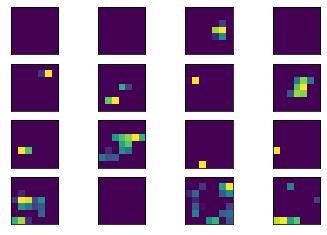

In [12]:
# plot 크기 square x square
square = 4
ix = 1
for i in range(square):
    for j in range(square):
        ax = pyplot.subplot(square,square,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # Feature Map
        pyplot.imshow(feature_map[0,:,:,ix-1])
        ix = ix + 1
pyplot.show()

2. 특징 추출 모델로 전이학습한 뒤, 평균과 분산을 출력하는 Variational AutoEncoder (vae) 모델을 사용해 이를 latent vector 로 압축한다.

3. 거리 파악 기술
latent vector 값의 거리를 구하는게 유사도임.

## VAE 모델 만들기

In [ ]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )
    #기본적으론 vae를 다 사용해서 나온 재구성된 이미지를 다시 인코딩해서 그렇게 나온 latent vector를 거리 계산해서 사용한다.
    #하지만.. 시간이 없기 때문에 vae모델의 중간에서 latent vector가 나올 때를 끊어서 차원 축소된 vector를 

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar